<p align="center">
  <img src="https://i.ytimg.com/vi/Wm8ftqDZUVk/maxresdefault.jpg" alt="FIUBA" width="33%"/>
  </p>
  
# **Trabajo Práctico 1: Reservas de Hotel**
### **Checkpoint**: 3
### **Grupo**: 11 - Los Pandas
### **Cuatrimestre**: 2ºC 2023
### **Corrector**: Mateo Suster
### **Integrantes**:
### 103456 - Labollita, Francisco
### 102312 - Mundani Vegega, Ezequiel
###  97263 - Otegui, Matías Iñaki

# Ensambles: Voting

Se busca tener varios modelos para que luego voten sobre el resultado del target.

In [11]:
import numpy as np
from scipy import stats
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegressionCV

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore', 'is_categorical_dtype is deprecated')
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

## Limpieza del dataset

Al momento de entrenar los modelos previos, no siempre se realizaron las mismas modificaciones sobre el dataset original. Por una cuestión de comodidad, se va a hacer que todos los modelos tengan el mismo dataset, por lo que se utilizará aquel en el que se transformaron algunos atributos en booleanos y se normalizaron las columnas numéricas cuantitativas. Esto es porque únicamente KNN no tuvo esta modificación y la normalización no afecta a los árboles pero sí a KNN.

In [2]:
hotels_df = pd.read_csv('hotels_train.csv')
hotels_df_backup = hotels_df.copy()

#Eliminación de columnas irrelevantes
hotels_df_mod = hotels_df.drop(['arrival_date_year', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'children', 'company', 'adr', 'id'], axis=1)

#Eliminación de filas con valores nulos
hotels_df_mod = hotels_df_mod.dropna(subset=['country', 'distribution_channel', 'market_segment'])

#Transformación de variables numéricas a booleanas
hotels_df_mod['required_car_parking_spaces'] = hotels_df_mod['required_car_parking_spaces'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['required_car_parking_spaces'] = hotels_df_mod['required_car_parking_spaces'].astype(bool)

hotels_df_mod['days_in_waiting_list'] = hotels_df_mod['days_in_waiting_list'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['days_in_waiting_list'] = hotels_df_mod['days_in_waiting_list'].astype(bool)

hotels_df_mod['babies'] = hotels_df_mod['babies'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['babies'] = hotels_df_mod['babies'].astype(bool)

hotels_df_mod['previous_cancellations'] = hotels_df_mod['previous_cancellations'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['previous_cancellations'] = hotels_df_mod['previous_cancellations'].astype(bool)

hotels_df_mod['total_of_special_requests'] = hotels_df_mod['total_of_special_requests'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['total_of_special_requests'] = hotels_df_mod['total_of_special_requests'].astype(bool)

hotels_df_mod['previous_bookings_not_canceled'] = hotels_df_mod['previous_bookings_not_canceled'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['previous_bookings_not_canceled'] = hotels_df_mod['previous_bookings_not_canceled'].astype(bool)

hotels_df_mod['booking_changes'] = hotels_df_mod['booking_changes'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['booking_changes'] = hotels_df_mod['booking_changes'].astype(bool)

#Eliminación de filas con outliers
hotels_df_mod = hotels_df_mod.drop(hotels_df_mod[hotels_df_mod['adults'] > 4].index)

#Agent sin definir es un valor válido, por lo que se reemplaza por Undefined
hotels_df_mod['agent'] = hotels_df_mod['agent'].astype(str)
hotels_df_mod['agent'] = hotels_df_mod['agent'].replace('nan', 'Undefined')

#Se cambia la columna reserved_room_type por room_type_match
hotels_df_mod = hotels_df_mod.rename(columns={'reserved_room_type': 'room_type_match'})

hotels_df_mod.loc[hotels_df_mod['room_type_match'] == hotels_df_mod['assigned_room_type'], 'room_type_match'] = True
hotels_df_mod.loc[hotels_df_mod['room_type_match'] != hotels_df_mod['assigned_room_type'], 'room_type_match'] = False
hotels_df_mod['room_type_match'] = hotels_df_mod['room_type_match'].astype(bool)

#Se normalizan los valores de las columnas numéricas cuantitativas
scaler = MinMaxScaler(feature_range=(0,1))
for col in hotels_df_mod.select_dtypes(include=[np.number, "int64", "float64"]).columns:
    hotels_df_mod[col] = scaler.fit_transform(hotels_df_mod[[col]])

#One-hot encoding para las columnas categóricas
hotels_df_mod = pd.get_dummies(hotels_df_mod, columns=["hotel", "arrival_date_month", "meal",
    "country", "market_segment", "distribution_channel", "assigned_room_type", "deposit_type",
    "customer_type", "agent" ], drop_first=True)

#Se ordenan las columnas
hotels_df_mod = hotels_df_mod.reindex(sorted(hotels_df_mod.columns), axis=1)

In [3]:
df_y = hotels_df_mod['is_canceled'].copy()
df_x = hotels_df_mod.drop(['is_canceled'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.30, random_state=0)

## Modelos del ensamble

### Modelo Árbol de Decisión (DT)

Se tendrá al árbol de decisión entrenado, con los mejores hiperparámetros obtenidos anteriormente. A pesar que los atributos cuantitativos numéricos del dataset fueron normalizados, esta modificación no debería generar ningún cambio en el F1-Score obtenido anteriormente.

In [4]:
dt_classifier = tree.DecisionTreeClassifier(ccp_alpha=3.8018939632056124e-05, max_depth=16, random_state=2, criterion='gini')

model = dt_classifier.fit(x_train,y_train)

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print("F1-Score sobre el set de entrenamiento:", round(f1_score(y_train, y_train_pred), 3))
print("F1-Score sobre el set de prueba:", round(f1_score(y_test, y_test_pred), 3))

F1-Score sobre el set de entrenamiento: 0.872
F1-Score sobre el set de prueba: 0.842


### Modelo K-Nearest Neighbors (KNN)

Se tendrá al modelo entrenado con KNN, con los mejores hiperparámetros obtenidos anteriormente. Tener en cuenta que el F1-Score obtenido no será el mismo porque el dataset tuvo una limpieza diferente.

In [5]:
knn_classifier = KNeighborsClassifier(n_neighbors=77, metric='canberra', weights='distance', n_jobs=-1)

model = knn_classifier.fit(x_train,y_train)

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print("F1-Score sobre el set de entrenamiento:", round(f1_score(y_train, y_train_pred), 3))
print("F1-Score sobre el set de prueba:", round(f1_score(y_test, y_test_pred), 3))

F1-Score sobre el set de entrenamiento: 0.994
F1-Score sobre el set de prueba: 0.838


### Modelo Support Vector Machine (SVM)

Se tendrá al SVM entrenado con sus hiperparámetros. Tener en cuenta que el F1-Score obtenido no será el mismo porque el dataset tuvo una limpieza diferente.

In [6]:
svm_classifier = SVC(kernel='poly', random_state = 2)
model = svm_classifier.fit(x_train,y_train)

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print("F1-Score sobre el set de entrenamiento:", round(f1_score(y_train, y_train_pred), 3))
print("F1-Score sobre el set de prueba:", round(f1_score(y_test, y_test_pred), 3))

F1-Score sobre el set de entrenamiento: 0.86
F1-Score sobre el set de prueba: 0.841


### Modelo Random Forest (RF)

Análogamente al decision tree, se tendrá al mejor bosque entrenado, con los mejores hiperparámetros obtenidos anteriormente. A pesar que los atributos cuantitativos numéricos del dataset fueron normalizados, esta modificación no debería generar ningún cambio en el F1-Score obtenido anteriormente.

In [7]:
rf_classifier = RandomForestClassifier(criterion = 'gini', 
                                        min_samples_leaf= 1, 
                                        min_samples_split= 4, 
                                        n_estimators=50, 
                                        oob_score=True,
                                        random_state=1,
                                        n_jobs=-1)

model = rf_classifier.fit(x_train,y_train)

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print("F1-Score sobre el set de entrenamiento:", round(f1_score(y_train, y_train_pred), 3))
print("F1-Score sobre el set de prueba:", round(f1_score(y_test, y_test_pred), 3))

F1-Score sobre el set de entrenamiento: 0.973
F1-Score sobre el set de prueba: 0.861


### Modelo XGBoost

Análogamente al decision tree, se tendrá al XGBoost, con los mejores hiperparámetros obtenidos anteriormente. A pesar que la limpieza del dataset fue distinta, los atributos cuantitativos numéricos del dataset fueron normalizados, esta modificación no debería generar ningún cambio en el F1-Score obtenido anteriormente.

In [8]:
xgb_classifier = xgb.XGBClassifier(colsample_bytree = 0.6, learning_rate = 0.1, max_depth = 10,
                                   n_estimators = 400, subsample = 0.7, random_state = 0, n_jobs = -1)

model = xgb_classifier.fit(x_train,y_train)

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print("F1-Score sobre el set de entrenamiento:", round(f1_score(y_train, y_train_pred), 3))
print("F1-Score sobre el set de prueba:", round(f1_score(y_test, y_test_pred), 3))

F1-Score sobre el set de entrenamiento: 0.926
F1-Score sobre el set de prueba: 0.866


## Armado del ensamble por votación

In [24]:
voting_classifier = VotingClassifier(estimators=[('dt', dt_classifier), ('knn', knn_classifier),
    ('svm', svm_classifier), ('rf', rf_classifier), ('xgb', xgb_classifier)], n_jobs=-1)

model_voting = voting_classifier.fit(x_train,y_train)

y_train_pred = model_voting.predict(x_train)
y_test_pred = model_voting.predict(x_test)

print("F1-Score sobre el set de entrenamiento:", round(f1_score(y_train, y_train_pred), 3))
print("F1-Score sobre el set de prueba:", round(f1_score(y_test, y_test_pred), 3))

F1-Score sobre el set de entrenamiento: 0.945
F1-Score sobre el set de prueba: 0.864


### Predicción del test armado a partir de hotels_train

Matriz de confusión de los datos de prueba


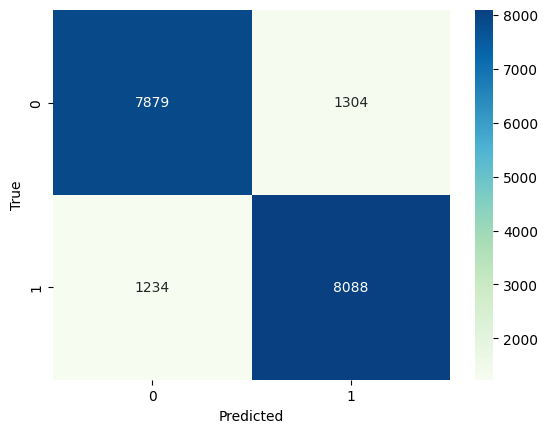

In [25]:
tabla=confusion_matrix(y_test, y_test_pred)
print("Matriz de confusión de los datos de prueba")
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True');

In [26]:
accuracy=accuracy_score(y_train, y_train_pred)
recall=recall_score(y_train, y_train_pred)
f1=f1_score(y_train, y_train_pred)
precision=precision_score(y_train, y_train_pred)

print("Cálculo de las métricas en el conjunto de entrenamiento")
print("Accuracy: ", round(accuracy, 3))
print("Recall: ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F1 score: ", round(f1, 3))

print(classification_report(y_train, y_train_pred))

Cálculo de las métricas en el conjunto de entrenamiento
Accuracy:  0.945
Recall:  0.952
Precision:  0.938
F1 score:  0.945
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.94     21617
         1.0       0.94      0.95      0.95     21559

    accuracy                           0.94     43176
   macro avg       0.94      0.94      0.94     43176
weighted avg       0.94      0.94      0.94     43176



In [27]:
accuracy=accuracy_score(y_test,y_test_pred)
recall=recall_score(y_test,y_test_pred)
f1=f1_score(y_test,y_test_pred)
precision=precision_score(y_test,y_test_pred)

print("Cálculo de las métricas en el conjunto de pruebas")
print("Accuracy: ", round(accuracy, 3))
print("Recall: ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F1 score: ", round(f1, 3))

print(classification_report(y_test, y_test_pred))

Cálculo de las métricas en el conjunto de pruebas
Accuracy:  0.863
Recall:  0.868
Precision:  0.861
F1 score:  0.864
              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86      9183
         1.0       0.86      0.87      0.86      9322

    accuracy                           0.86     18505
   macro avg       0.86      0.86      0.86     18505
weighted avg       0.86      0.86      0.86     18505



## Armado del ensamble stacking

In [28]:
base_models = [('dt', dt_classifier),
               ('knn', knn_classifier),
               ('svm', svm_classifier),
               ('rf', rf_classifier),
               ('xgb', xgb_classifier)]

meta_model = LogisticRegressionCV()

stacking_classifier = StackingClassifier(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=True, 
                                    cv=5)

model_stacking = stacking_classifier.fit(x_train,y_train)

y_train_pred = model_stacking.predict(x_train)
y_test_pred = model_stacking.predict(x_test)

print("F1-Score sobre el set de entrenamiento:", round(f1_score(y_train, y_train_pred), 3))
print("F1-Score sobre el set de prueba:", round(f1_score(y_test, y_test_pred), 3))

F1-Score sobre el set de entrenamiento: 0.977
F1-Score sobre el set de prueba: 0.868


### Predicción del test armado a partir de hotels_train

Matriz de confusión de los datos de prueba


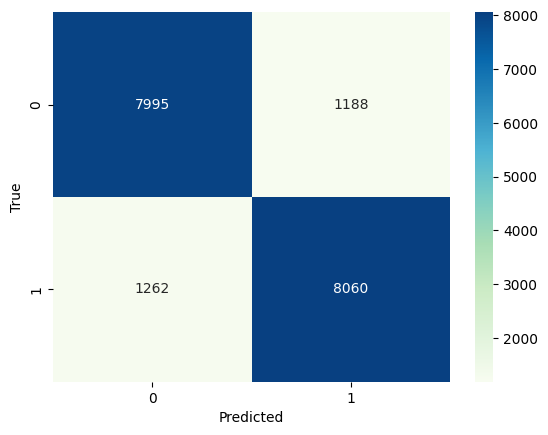

In [29]:
tabla=confusion_matrix(y_test, y_test_pred)
print("Matriz de confusión de los datos de prueba")
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True');

In [30]:
accuracy=accuracy_score(y_train, y_train_pred)
recall=recall_score(y_train, y_train_pred)
f1=f1_score(y_train, y_train_pred)
precision=precision_score(y_train, y_train_pred)

print("Cálculo de las métricas en el conjunto de entrenamiento")
print("Accuracy: ", round(accuracy, 3))
print("Recall: ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F1 score: ", round(f1, 3))

print(classification_report(y_train, y_train_pred))

Cálculo de las métricas en el conjunto de entrenamiento
Accuracy:  0.977
Recall:  0.977
Precision:  0.978
F1 score:  0.977
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     21617
         1.0       0.98      0.98      0.98     21559

    accuracy                           0.98     43176
   macro avg       0.98      0.98      0.98     43176
weighted avg       0.98      0.98      0.98     43176



In [31]:
accuracy=accuracy_score(y_test,y_test_pred)
recall=recall_score(y_test,y_test_pred)
f1=f1_score(y_test,y_test_pred)
precision=precision_score(y_test,y_test_pred)

print("Cálculo de las métricas en el conjunto de pruebas")
print("Accuracy: ", round(accuracy, 3))
print("Recall: ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F1 score: ", round(f1, 3))

print(classification_report(y_test, y_test_pred))

Cálculo de las métricas en el conjunto de pruebas
Accuracy:  0.868
Recall:  0.865
Precision:  0.872
F1 score:  0.868
              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87      9183
         1.0       0.87      0.86      0.87      9322

    accuracy                           0.87     18505
   macro avg       0.87      0.87      0.87     18505
weighted avg       0.87      0.87      0.87     18505



## Predicción de hotels_test

Se modifica el dataset de test de manera similar al de train, para que el modelo obtenido pueda ser aplicado.

In [32]:
test_df = pd.read_csv('hotels_test.csv')

test_df_mod = test_df.copy()

#Se guarda el id de cada fila para luego poder identificarla
id_backup = test_df_mod[['id']].copy()

#Se cambia la columna reserved_room_type por room_type_match
test_df_mod = test_df_mod.rename(columns={'reserved_room_type': 'room_type_match'})

test_df_mod.loc[test_df_mod['room_type_match'] == test_df_mod['assigned_room_type'], 'room_type_match'] = True
test_df_mod.loc[test_df_mod['room_type_match'] != test_df_mod['assigned_room_type'], 'room_type_match'] = False
test_df_mod['room_type_match'] = test_df_mod['room_type_match'].astype(bool)

#Agent sin definir es un valor válido, por lo que se reemplaza por Undefined
test_df_mod['agent'] = test_df_mod['agent'].astype(str)
test_df_mod['agent'] = test_df_mod['agent'].replace('nan', 'Undefined')

#Transformación de variables numéricas a booleanas 
test_df_mod['required_car_parking_spaces'] = test_df_mod['required_car_parking_spaces'].apply(lambda x: True if x >= 1 else False)
test_df_mod['required_car_parking_spaces'] = test_df_mod['required_car_parking_spaces'].astype(bool)

test_df_mod['days_in_waiting_list'] = test_df_mod['days_in_waiting_list'].apply(lambda x: True if x >= 1 else False)
test_df_mod['days_in_waiting_list'] = test_df_mod['days_in_waiting_list'].astype(bool)

test_df_mod['babies'] = test_df_mod['babies'].apply(lambda x: True if x >= 1 else False)
test_df_mod['babies'] = test_df_mod['babies'].astype(bool)

test_df_mod['previous_cancellations'] = test_df_mod['previous_cancellations'].apply(lambda x: True if x >= 1 else False)
test_df_mod['previous_cancellations'] = test_df_mod['previous_cancellations'].astype(bool)

test_df_mod['total_of_special_requests'] = test_df_mod['total_of_special_requests'].apply(lambda x: True if x >= 1 else False)
test_df_mod['total_of_special_requests'] = test_df_mod['total_of_special_requests'].astype(bool)

test_df_mod['previous_bookings_not_canceled'] = test_df_mod['previous_bookings_not_canceled'].apply(lambda x: True if x >= 1 else False)
test_df_mod['previous_bookings_not_canceled'] = test_df_mod['previous_bookings_not_canceled'].astype(bool)

test_df_mod['booking_changes'] = test_df_mod['booking_changes'].apply(lambda x: True if x >= 1 else False)
test_df_mod['booking_changes'] = test_df_mod['booking_changes'].astype(bool)

test_df_mod = test_df_mod.drop(['arrival_date_year', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'children', 'company', 'adr', 'id'], axis=1)
test_df_mod = test_df_mod.drop(['reservation_status_date'], axis='columns') #Esta es la columna que no debería estar en el dataset de test

#Se normalizan los valores de las columnas numéricas cuantitativas
scaler = MinMaxScaler(feature_range=(0,1))
for col in test_df_mod.select_dtypes(include=[np.number, "int64", "float64"]).columns:
    test_df_mod[col] = scaler.fit_transform(test_df_mod[[col]])

#One-hot encoding para las columnas categóricas
test_df_mod = pd.get_dummies(test_df_mod, columns=["hotel", "arrival_date_month", "meal", "country", "market_segment", "distribution_channel", "assigned_room_type", "deposit_type", "customer_type", "agent" ], drop_first=True)

#Se crean las columnas que están en el df para entrenar pero no en el df a predecir
for col in df_x.columns:
    if col not in test_df_mod.columns:
        test_df_mod[col] = False

#Se eliminan las columnas que están en el df para predecir pero no en el df para entrenar
for col in test_df_mod.columns:
    if col not in df_x.columns:
        test_df_mod = test_df_mod.drop(columns=[col])

#Se ordenan las columnas
test_df_mod = test_df_mod.reindex(sorted(test_df_mod.columns), axis=1)

In [33]:
#Se realiza una predicción sobre test utilizando el ensamble voting
y_pred = model.predict(test_df_mod)

predictions = pd.DataFrame()

predictions['id'] = id_backup['id'].values
predictions['is_canceled'] = y_pred.astype(int)

predictions.to_csv('sample_submission_voting.csv', index=False)

In [34]:
#Se realiza una predicción sobre test utilizando el ensamble stacking
y_pred = model_stacking.predict(test_df_mod)

predictions = pd.DataFrame()

predictions['id'] = id_backup['id'].values
predictions['is_canceled'] = y_pred.astype(int)

predictions.to_csv('sample_submission_stacking.csv', index=False)